## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Development Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
from matplotlib import pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    # Returns 2nd PPG channel and all three ACC channels
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(np.array(errs))
    confs = np.hstack(np.array(confs))
    return AggregateErrorMetric(errs, confs)

Text(0,0.5,'Frequency (Hz)')

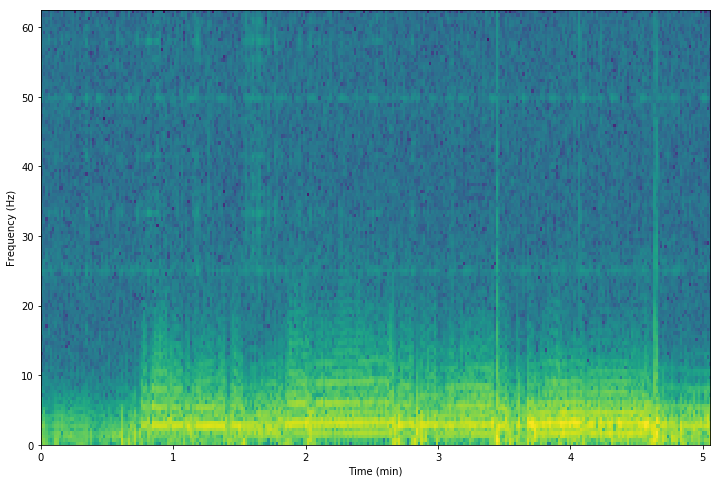

In [2]:
# Plot the spectrogram for the PPG signal
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

fs = 125
plt.figure(figsize=(12, 8))
plt.specgram(ppg, Fs=fs, NFFT=250, noverlap=125, xextent=[0, len(ppg) / fs / 60]);
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

In [3]:
# Define a bandpass filter

def BandpassFilter(signal, fs, low_freq, high_freq):
    """
    *** DONE ***
    Applies a bandpass filter to a signal.
    
    Args:
        signal: (np.array) The input signal
        fs: sampling frequency
        low_freq: low frequency limit in Hz
        high_freq: high frequency limit in Hz
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(5, (low_freq, high_freq), btype='bandpass', fs=fs)
    
    return sp.signal.filtfilt(b, a, signal)

Text(0,0.5,'Frequency (Hz)')

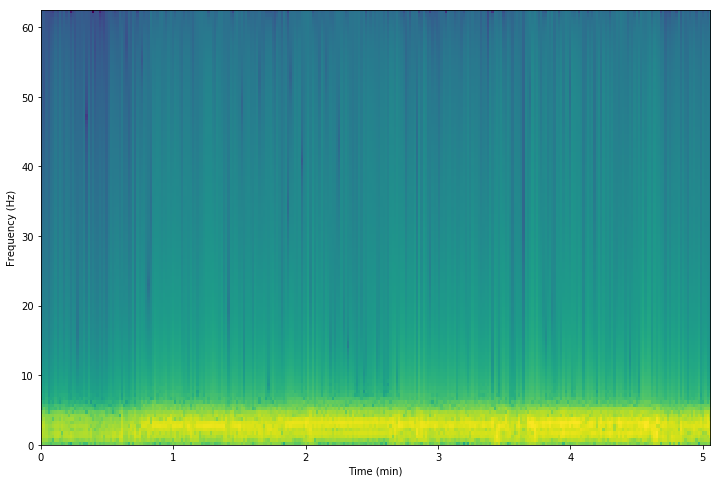

In [4]:
# Filter out the noise from the PPG signal using the bandpass filter
# Use values defined in Part 1 README.md and TroikaDataset README.pdf
fs = 125
low_freq = 40/60 # Divide BPM by 60 to get Hz
high_freq = 240/60

plt.figure(figsize=(12, 8))
filtered_ppg = BandpassFilter(ppg, fs, low_freq, high_freq)
plt.specgram(filtered_ppg, Fs=fs, NFFT=250, noverlap=125, xextent=[0, len(ppg) / fs / 60]);
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

Text(0.5,0,'Frequency (Hz)')

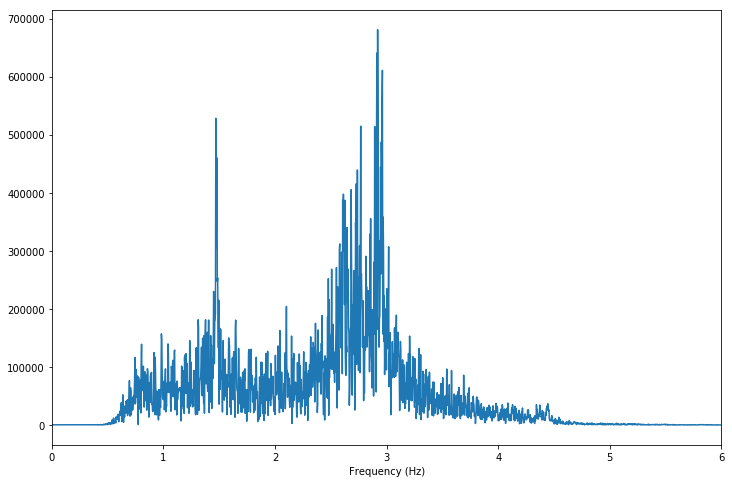

In [5]:
# Adjust the x-axis to focus on lower frequencies for the PPG signal
plt.figure(figsize=(12, 8))
plt.xlim(0, 6)
plt.plot(np.fft.rfftfreq(len(ppg), 1/fs), np.abs(np.fft.rfft(filtered_ppg)))
plt.xlabel('Frequency (Hz)')

Text(0,0.5,'Frequency (Hz)')

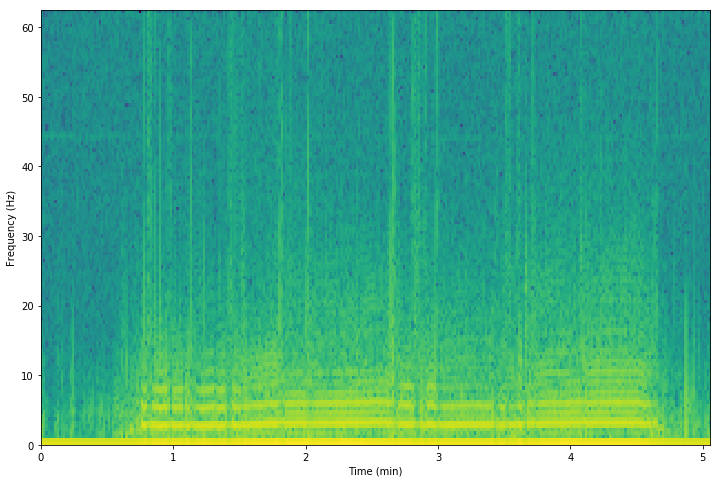

In [6]:
# Plot the spectrogram for the ACC signal
# Gravity acts in y-channel as given in: https://knowledge.udacity.com/questions/224181
acc = np.sqrt(accx**2 + accy**2 + accz**2)
plt.figure(figsize=(12, 8))
plt.specgram(acc, Fs=fs, NFFT=250, noverlap=125, xextent=[0, len(acc) / fs / 60]);
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

Text(0,0.5,'Frequency (Hz)')

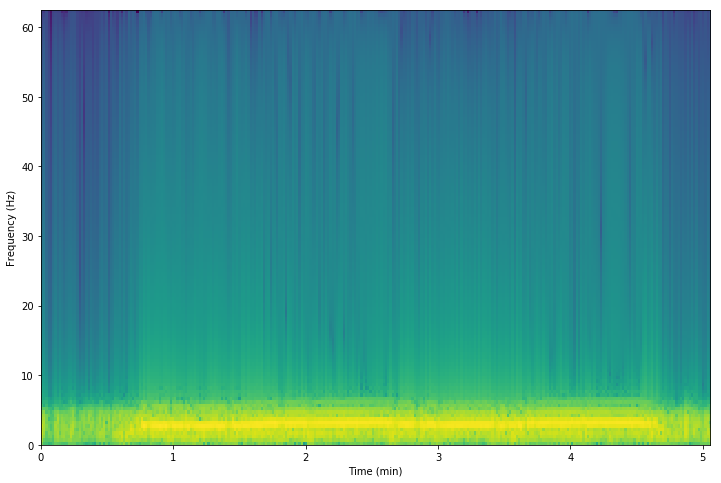

In [7]:
# Filter out the noise from the ACC signal using the bandpass filter
plt.figure(figsize=(12, 8))
filtered_acc = BandpassFilter(acc, fs, low_freq, high_freq)
plt.specgram(filtered_acc, Fs=fs, NFFT=250, noverlap=125, xextent=[0, len(acc) / fs / 60]);
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

Text(0.5,0,'Frequency (Hz)')

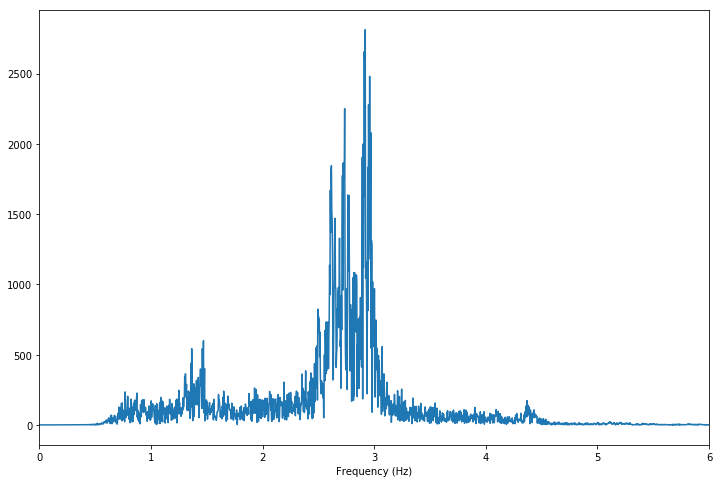

In [8]:
# Adjust the x-axis to focus on lower frequencies for the ACC signal
plt.figure(figsize=(12, 8))
plt.xlim(0, 6)
plt.plot(np.fft.rfftfreq(len(acc), 1/fs), np.abs(np.fft.rfft(filtered_acc)))
plt.xlabel('Frequency (Hz)')

#### Spectral Domain Observations

Comparing the ACC and PPG signals, it appears that:
- Heart rate corresponds to the 2nd largest peak at ~1.5 Hz or ~90 BPM
- Arm / body movement corresponds to the peaks around 2.5-3.0 Hz

Therefore, we should be able to use total energy within the 1-2Hz band to separate the heart rate-generated peak from the motion-generated peaks.

Mean of ACC x-channel is 3.50396521062e-05


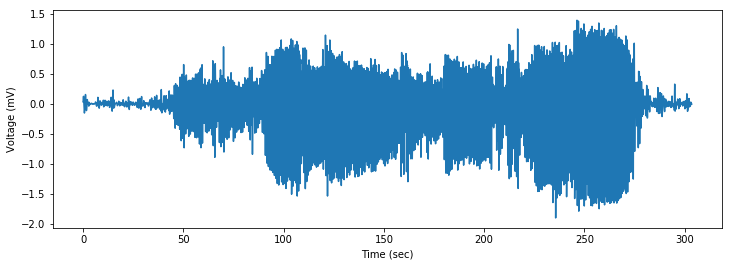

In [9]:
# Plot time series for ACC signal for x-channel
filtered_accx = BandpassFilter(accx, fs, low_freq, high_freq)
ts = np.arange(len(accx)) / fs
plt.figure(figsize=(12, 4))
plt.plot(ts, filtered_accx)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (sec)')
print("Mean of ACC x-channel is", np.mean(filtered_accx))

Mean of ACC x-channel is 1.69366778333e-05


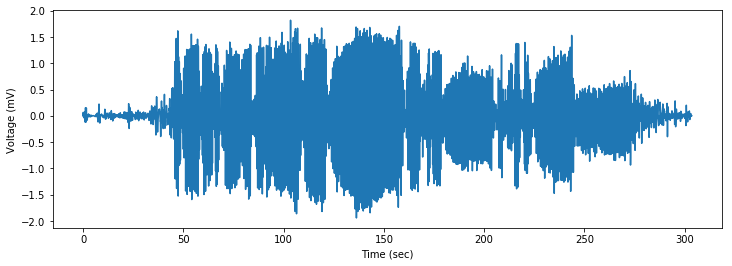

In [10]:
# Plot time series for ACC signal for y-channel
filtered_accy = BandpassFilter(accy, fs, low_freq, high_freq)
ts = np.arange(len(accy)) / fs
plt.figure(figsize=(12, 4))
plt.plot(ts, filtered_accy)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (sec)')
print("Mean of ACC x-channel is", np.mean(filtered_accy))

Mean of ACC x-channel is -4.61078473277e-05


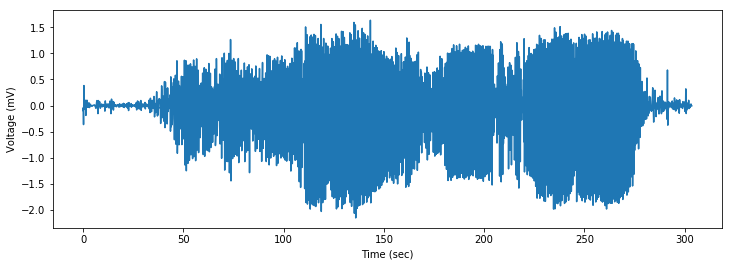

In [11]:
# Plot time series for ACC signal for z-channel
filtered_accz = BandpassFilter(accz, fs, low_freq, high_freq)
ts = np.arange(len(accz)) / fs
plt.figure(figsize=(12, 4))
plt.plot(ts, filtered_accz)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (sec)')
print("Mean of ACC x-channel is", np.mean(filtered_accz))

#### Time Domain Observations

Comparing the ACC signals across all channels, it appears that:
- The mean of all channel signal strength is ~0.
- Therefore, there is no obvious channel that is affected by the gravitational force.

### Final Code

In [12]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
from matplotlib import pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    # Returns 2nd PPG channel and all three ACC channels
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(np.array(errs))
    confs = np.hstack(np.array(confs))
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Performs activities comprising the signal analysis pipeline:
        Filter Noise -> Train Heuristic -> Predict PR -> Compute Confidence
    
    Args:
        data_fl: Name of the .mat files that contain signal data
        ref_fl: Name of the .mat files that contain reference data

    Returns:
        numpy arrays for pulse rate errors and confidences.
    """
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_pr = sp.io.loadmat(ref_fl)['BPM0']

    # Define initial values
    fs = 125                                     # Part 1 README.md
    low_freq, high_freq = 40/60, 240/60          # TroikaDataset README.pdf
    errors, confidence = np.array([]), np.array([])

    # Apply bandpass filter to PPG and ACC signal to remove noise
    ppg_filtered = BandpassFilter(ppg, fs, low_freq, high_freq)
    accx_filtered = BandpassFilter(accx, fs, low_freq, high_freq)
    accy_filtered = BandpassFilter(accy, fs, low_freq, high_freq)
    accz_filtered = BandpassFilter(accz, fs, low_freq, high_freq)

    # Train on 8 second windows with 2 second overlaps to match ground-truth measurements
    window_length_s = 8
    window_shift_s = 2
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    end_index = min(len(ppg), len(ref_pr) * fs * 2)
    est_last = 0
    
    for i in range(0, (end_index - window_length), window_shift):
        
        # Compute slice of signal
        ppg_window = ppg_filtered[i: i + window_length]
        accx_window = accx_filtered[i: i + window_length]
        accy_window = accy_filtered[i: i + window_length]
        accz_window = accz_filtered[i: i + window_length]

        # Find PPG and ACC peaks (frequencies)
        ppg_peaks_f, ppg_peaks_m, ppg_freq, ppg_fft = ListPeaks(ppg_window, fs)
        accx_peaks_f, _, _, _ = ListPeaks(accx_window, fs)
        accy_peaks_f, _, _, _ = ListPeaks(accy_window, fs)
        accz_peaks_f, _, _, _ = ListPeaks(accz_window, fs)
        
        """
        ## Code for debugging purposes
        if i < 10:
            # Plot PPG signal
            x = ref_pr[int(i/(fs*2))]/60
            y = max(ppg_peaks_m)
            plt.figure(figsize=(12, 8))
            plt.xlim(0, 6)
            plt.plot((x, x), (0, y), 'g-')
            plt.plot(ppg_freq, ppg_fft)
            plt.plot(ppg_peaks_f, ppg_peaks_m, 'r.', ms=10)
            plt.xlabel('Frequency (Hz)')
        """
        
        # Find best estimated pulse rate
        est_pr = FindBestPR(ppg_peaks_f, ppg_peaks_m, accx_peaks_f, accy_peaks_f, accz_peaks_f)
        est_pr_bpm = est_pr * 60                 # Multiplying by 60 to get BPM
    
        # Compute absolute error for pulse rate estimate
        err = np.abs(est_pr_bpm - ref_pr[int(i/(fs*2))])
        
        """
        ## Code for debugging purposes
        # Plot pulse rate estimates with high errors relative to reference pulse rate
        if err > 80:
            # Plot PPG signal
            x_ref = ref_pr[int(i/(fs*2))]/60
            x_pred =est_pr
            y = max(ppg_peaks_m)
            plt.figure(figsize=(12, 8))
            plt.xlim(0, 6)
            plt.plot((x_ref, x_ref), (0, y), 'g-')
            plt.plot(ppg_freq, ppg_fft)
            plt.plot((x_pred, x_pred), (0, y), 'r-')
            plt.xlabel('Frequency (Hz)')
        """
        
        # Use last good estimate if error is high
        if err > 15:
            est_pr = est_last
        else:
            est_last = est_pr

        errors = np.append(errors, err)
    
        # Compute estimation confidence for pulse rate estimate
        conf = CalcConfidence(est_pr, ppg_freq, ppg_fft)
        confidence = np.append(confidence, conf)
        
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence

def BandpassFilter(signal, fs, low_freq, high_freq):
    """
    Applies a bandpass filter to a signal.
    
    Args:
        signal: (np.array) The input signal.
        fs: sampling frequency.
        low_freq: low frequency limit in Hz.
        high_freq: high frequency limit in Hz.
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(1, (low_freq, high_freq), btype='bandpass', fs=fs)
    
    return sp.signal.filtfilt(b, a, signal)

def ListPeaks(signal, fs):
    """
    Calculates frequency peaks for signal
    
    Args:
        signal: (np.array) The input signal
        fs: sampling frequency.
        height: height parameter for SCIPY find_peaks function.
        distance: height parameter for SCIPY find_peaks function..

    Returns:
        numpy arrays for signal peak frequencies and FFTs, signal frequencies and FFTs.
    """
    
    # Compute the FFT of the signal
    fft_len = len(signal) * 4                    # 0-pad signal
    freqs = np.fft.rfftfreq(fft_len, 1/fs)
    fft_mag = np.abs(np.fft.rfft(signal, fft_len))
    fft_mag[freqs <= 40/60.0] = 0.0
    fft_mag[freqs >= 240/60.0] = 0.0
    
    # Calculate peak indices in the signal
    #print(max(fft_mag), height)
    peaks_ind = sp.signal.find_peaks(fft_mag)[0]
    
    # Citation: Udacity Knowledge at https://knowledge.udacity.com/questions/224181
    # Sort peak magnitudes strongest to weakest 
    peaks_mag = []
    for i in peaks_ind:
        peaks_mag.append(fft_mag[i])
    peaks_mag = sorted(peaks_mag)[::-1]
    
    # Sort peak frequencies from strongest to weakest magnitude
    peaks_freq = []
    for m in peaks_mag:
        peaks_freq.append(freqs[np.where(fft_mag==m)[0][0]])
    
    return peaks_freq, peaks_mag, freqs, fft_mag

def FindBestPR(ppg_peaks_f, ppg_peaks_m, accx_peaks_f, accy_peaks_f, accz_peaks_f):
    """
    Computes best pulse rate given PPG and ACC peaks
    
    Args:
        ppg_peaks_f: (np.array) Array of PPG signal frequency peaks.
        ppg_freqs_m: (np.array) Array of PPG signal frequency peaks.
        accx_peaks_f: (np.array)  Array of ACC x-channel frequency peaks.
        accy_peaks_f: (np.array)  Array of ACC y-channel frequency peaks.
        accz_peaks_f: (np.array)  Array of ACC z-channel frequency peaks.

    Returns:
        best estimated pulse rate.
    """
    # Initialize selection parameters
    band = 5 / 60                                # BPM divided by 60 for Hz
    threshold = 0.35 * max(ppg_peaks_m)
    
    # Loop through all PPG peaks to identify best one
    for i in range(0, len(ppg_peaks_m)):

        # Consider candidate peak if strong enough
        if ppg_peaks_m[i] > threshold:

            # Select peak if not similar to any dominant ACC channel frequency
            low_freq = ppg_peaks_f[i] - band
            high_freq = ppg_peaks_f[i] + band
            
            accx_test = (accx_peaks_f[0] < low_freq) or (accx_peaks_f[0] > high_freq)
            accy_test = (accy_peaks_f[0] < low_freq) or (accy_peaks_f[0] > high_freq)
            accz_test = (accz_peaks_f[0] < low_freq) or (accz_peaks_f[0] > high_freq)
            
            if (accx_test and accy_test and accz_test):
                return ppg_peaks_f[i]
    
    # Use highest PPG peak as best estimated pulse rate if no alternatives are found    
    return ppg_peaks_f[0]

def CalcConfidence(est_pr, ppg_freqs, ppg_fft):
    """
    Confidence based on signal power around estimated heart rate
    
    Args:
        est_pr: The pulse rate estimate.
        ppg_freqs: (np.array) PPG frequencies.
        ppg_fft: (np.array) PPG FFT magnitudes.

    Returns:
        numpy array for confidence.
    """
    # Define frequency window centered on estimated pulse rate
    freq_width = 40 / 60                         # bpm divided by 60 for Hz
    freq_window = (ppg_freqs > est_pr - freq_width) & (ppg_freqs < est_pr + freq_width)
    
    # Calcuate power of pulse rate signal and the total power
    signal_power = np.sum(ppg_fft[(freq_window)])
    total_power = np.sum(ppg_fft)
    
    # Calculate confidence of pulse rate estimate
    confidence = signal_power / total_power
    
    return confidence

In [16]:
Evaluate()

7.7146005775975084

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

### Code Description

For this project I created a pulse rate estimation algorithm for a wrist-wearable device. I used information on the physiological mechanics of pulse rate estimation to design my algorithm. Pulse rate is typically estimated by using a PPG sensor, but arm movement can cause periodic signals in the PPG. Fortunately, you can use an accelerometer signal, which only senses arm motion, to help isolate the pulse rate signals from arm motion signals.

My code performs three primary functions. It loads the dataset, runs the primary algorithm pipeline, then evaluates the algorithm. Wihtin the algorithm pipeline, it runs through four steps:
1. Filters noise from PPG and ACC signals.
2. Trains the heuristic to identify key features.
3. Predicts an estimated pulse rate.
4. Computes absolute errors and confidence.


### Data Description

Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously recorded from subjects with age from 18 to 35. For each subject, the PG signals were recorded from the wrist by two pulse oximeters, and the acceleration signal was recorded from teh write by a three-axis accelerometer. The ECG signal was recordd simultaneiously from the chest using wet ECG sensors. All signals were sampled at 125 Hz.

Each dataset with a similar name 'DATA_01_TYPE01' contains a variable 'sig' with 6 rows: ECG, PPG channel one, PPG channel two, ACC x-channel, ACC y-channel, and ACC z-channel. During data recording, each subject ran on a treadmill with changing speeds. The ground-truth heart rate can be calcualted from the ECG signal, but it is also stored in a dataset with a corresponding name 'REF_01_TYPE01'. A variable 'BPMO' gives the BPM value in every 8-second window, with successive windows overlaping by 6 seconds.

There are a few shortcomings with this dataset. First, subjects were aged 18-35, so my algorithm may not be applicable to children and middle-aged or older adults. Second, there is no information on gender, race, so it is unclear whether the dataset may be biased. Finally, and most importantly, there were only 12 subjects in this dataset, which limits the ability to improve my algorithm.

To overcome these shortcoming, a larger, more diverse dataset would be helpful, encompassing a wider range of age, gender, and race, as well as perhaps health conditions, to ensure that my algorithm could be trained and perform more effectively for a broader segment of the population.

**Reference**:
Zhilin Zhang, Zhouyue Pi, Benyuan Liu, "TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise," IEEE Trans. on Miomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015.


### Algorithm Description

#### How the algorithm works:
1. **Load Dataset**. *LoadTroikaDataset* retrieves file names from the Troika dataset (see Data Description for details), while *LoadTroikaDataFile* loads and extracts signals from the files.
2. **Run Algorithm**. *RunPulseRateAlgorithm* runs the algorithm pipeline, which consists of four steps: 
    1. **Filter Noise**. #BandpassFilter# applies a bandpass filter to PPG signal and all ACC channel signals. Filter range has been defined as 40bpm to 240bpm, to correspond with reasonable physiological limits to pulse rates.
    2. **Train Heuristic**. The heuristic was trained on 8 second windows with 2 second overlaps, which matches the reference pulse rates present in the dataset. Peaks were identified via the *ListPeaks* function which by calculating the fast fourier transforms of the PPG and ACC signals (transforming them into spectral space), and running the SCIPY *find_peaks* function. Peaks were then sorted according to magnitude.
    3. **Predict Pulse Rate**. *FindBestPR* finds the best pulse rate estimate by identifying the strongest PPG peak which does not overlap with any of the ACC channel peaks. As a final check on this estimate, *RunPulseRateAlgorithm* uses the estimate from the previous window if errors are too high with respect to reference pulse rates. 
    4. **Compute Errors and Confidence**. Finally, *RunPulseRateAlgorithm* calculates absolute errors with respect to the reference pulse rate, and *CalcConfidence* determines confidence based on the ratio of signal power around the pulse rate estimate to total power.
3. **Evaluate Algorithm**. *Evaluate* runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric calculated via the *AggregateErrorMetric* function.

#### Specific aspects of physiology it leverages:
Pulse rate is typically estimated by using the PPG sensor. When the ventricles contract, the capillaries in the wrist fill with blood. The (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capillaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate.

However, the heart beating is not the only phenomenon that modulates the PPG signal. Blood in the wrist is fluid, and arm movement will cause the blood to move correspondingly. During exercise, like walking or running, we see another periodic signal in the PPG due to this arm motion. The pulse rate estimator has to be careful not to confuse this periodic signal with the pulse rate.

We can use the accelerometer signal of our wearable device to help us keep track of which periodic signal is caused by motion. Because the accelerometer is only sensing arm motion, any periodic signal in the accelerometer is likely not due to the heart beating, and only due to the arm motion. If the pulse rate estimator is picking a frequency that's strong in the accelerometer, it may be making a mistake.

#### Description of the algorithm outputs:
The algorithm outputs an aggregate error metric based on confidence estimates. It returns the mean absolute error (MAE) at 90% availability. Higher confidence means a better estimate. The best 90% of the estimates are above the 10th percentile confidence.

#### Caveats on algorithm outputs:
Many machine learning algorithms produce outputs that can be used to estimate their per-result error. We call this estimation of the algorithm's error the confidence.

In pulse rate estimation, having a confidence value can be useful if a user wants just a handful of high-quality pulse rate estimate per night. They can use the confidence algorithm to select the 20 most confident estimates at night and ignore the rest of the outputs. Confidence estimates can also be used to set the point on the error curve that we want to operate at by sacrificing the number of estimates that are considered valid. There is a trade-off between availability and error. For example, if we want to operate at 10% availability, we look at our training dataset to determine the confidence threshold for which 10% of the estimates pass. Then if only if an estimate's confidence value is above that threshold, do we consider it valid. See the error vs. availability curve below.

#### Common failure modes:
There are several potential causes of failure for this algorithm. These include:
* Finding too many peaks. The SCIPY find_peaks function can be overly sensitive, and identify so many peaks that accurate prediction of pulse rate can be difficult. This can be mitigated by using parameters like *height* and *distance* to capture only the strongest and most distinct peaks.
* Overlap between PPG and ACC signals. Sometimes the cadence of the arm swing is the same as the heartbeat. In this case, if a good candidate pulse rate can't be found outside the ACC peak, it may be the same as the accelerometer.


### Algorithm Performance

Algorithm performance was computed using a train-test split. The TROIKA dataset, consisting of 12 files, was used for training, while another dataset of similar size was used for testing. Performance was optimized to minimize the mean absolute error (MAE) at 90% availability. 

Error metrics that would be relevant to users of my algorithm include mean absolute error, and confidence based on the ratio of signal power around the pulse rate estimate to total signal power. 

While this algorithm achieved an MAE at 90% availability of 7.71 BPM on the test set and 2.49 BPM on the test set, these performance numbers are not widely generalizable. As mentioned above, they may not be applicable for individuals outside of 18-35 years old, and many not be generalizable across genders and races.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 